# VOWEL FORMANTS

In [72]:
# DON'T FORGET TO RUN THIS CELL
import math
import numpy as np
import pandas as pd
import seaborn as sns
import datascience as ds
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Exploring TIMIT Data

We will start off by exploring and analyze real TIMIT data taken from 8 different regions of the TIMIT corpus. These measurements are taken at the midpoint of vowels, and vowel boundaries were determined automatically using forced alignment (Penn FA).

### Uploading the data

Prior to being able to work with the data, we have to upload our dataset. The following two lines of code will read in our data and create a dataframe. The last line of code prints the `timit` dataframe, but instead of printing the whole dataframe, by using the method `.head`, it only prints the first 5 rows.

In [73]:
timit = pd.read_csv('data/timitvowels.csv')
timit.head()

,speaker,gender,region,height,word,vowel,duration,F1,F2,F3,f0
0,cjf0,female,1,162.56,SHE,IY,0.08,486.2,2467.9,3185.1,244.9
1,cjf0,female,1,162.56,HAD,AE,0.10,595.1,2067.0,2976.7,241.6
2,cjf0,female,1,162.56,YOUR,UH,0.04,468.7,1956.1,3061.4,201.9
3,cjf0,female,1,162.56,DARK,AA,0.10,740.4,1674.1,2767.3,221.5
4,cjf0,female,1,162.56,SUIT,UW,0.17,464.0,1698.0,2904.9,232.6


Look at the dataframe you created and try to figure out what each column measures. Each column represents a different attribute, see the following table for more information.

|Column Name|Details|
|---|---|
|speaker|unique speaker ID|
|gender|Speaker’s self-reported gender|
|region|Speaker dialect region number|
|word|Lexical item (from sentence prompt)|
|vowel|Vowel ID|
|duration|Vowel duration (seconds)|
|F1/F2/F3/f0|f0 and F1-F3 in BPM (Hz)|

Sometimes data is encoded with with an identifier, or key, to save space and simplify calculations. Each of those keys corresponds to a specific value. If you look at the `region` column, you will notice that all of the values are numbers. Each of those numbers corresponds to a region, for example, in our first row the speaker, `cjf0`, is from region `1`. That corresponds to New England. Below is a table with all of the keys for `region`.

|Key|Region|
|---|---|
|1|New England|
|2|Northern|
|3|North Midland|
|4|South Midland|
|5|Southern|
|6|New York City|
|7|Western|
|8|Army Brat|

### Transformations

When inspecting data, you may realize that there are changes to be made -- possibly due to the representation to the data or errors in the recording. Before jumping into analysis, it is important to clean the data. 

One thing to notice about `timit` is that the column `vowel` contains ARPABET identifiers for the vowels. We want to convert the vowel column to be IPA characters, and will do so in the cell below.

In [74]:
IPAdict = {"AO" : "ɔ", "AA" : "ɑ", "IY" : "i", "UW" : "u", "EH" : "ɛ", "IH" : "ɪ", "UH":"ʊ", "AH": "ʌ", "AX" : "ə", "AE":"æ", "EY" :"eɪ", "AY": "aɪ", "OW":"oʊ", "AW":"aʊ", "OY" :"ɔɪ", "ER":"ɚ"}
timit['vowel'] = [IPAdict[x] for x in timit['vowel']]
timit.head()

,speaker,gender,region,height,word,vowel,duration,F1,F2,F3,f0
0,cjf0,female,1,162.56,SHE,i,0.08,486.2,2467.9,3185.1,244.9
1,cjf0,female,1,162.56,HAD,æ,0.10,595.1,2067.0,2976.7,241.6
2,cjf0,female,1,162.56,YOUR,ʊ,0.04,468.7,1956.1,3061.4,201.9
3,cjf0,female,1,162.56,DARK,ɑ,0.10,740.4,1674.1,2767.3,221.5
4,cjf0,female,1,162.56,SUIT,u,0.17,464.0,1698.0,2904.9,232.6


Most of the speakers will say the same vowel multiple times, so we are going to average those values together. The end result will be a dataframe where each row represents the average values for each vowel for each speaker.

In [75]:
timit_avg = timit.groupby(['speaker', 'vowel', 'gender', 'region']).mean().reset_index()
timit_avg.head()

,speaker,vowel,gender,region,height,duration,F1,F2,F3,f0
0,/1/2000,eɪ,male,2,175.26,0.105000,447.20,1947.233333,2547.466667,138.366667
1,/1/2000,i,male,2,175.26,0.063333,374.00,1995.966667,2529.666667,137.266667
2,/1/2000,oʊ,male,2,175.26,0.080000,498.75,1242.300000,2523.050000,142.100000
3,/1/2000,u,male,2,175.26,0.060000,407.85,1157.050000,2353.200000,148.150000
4,/1/2000,æ,male,2,175.26,0.098000,690.98,1715.980000,2548.220000,145.100000


### Splitting on Gender

Using the same dataframe from above, `timit_avg`, we are going to split into dataframes grouped by gender. To identify the possible values of gender in the `gender` column, we can use the method `.unique` on the column.

In [76]:
timit_avg.gender.unique()

array(['male', 'female'], dtype=object)

You could see that for this specific dataset there are only "female" and "male" values in the column. Given that information, we'll create two subsets based off of gender. 

We'll split `timit_avg` into two separate dataframes, one for females, `timit_female`, and one for males, `timit_male`. Creating these subset dataframes does not affect the original `timit_avg` dataframe.

In [77]:
timit_female = timit_avg[timit_avg['gender'] == 'female']
timit_male = timit_avg[timit_avg['gender'] == 'male']

### Distribution of Formants

We want to inspect the distributions of F1, F2, and F3 for those that self-report as male and those that self-report as female to identify possible trends or relationships. Having our two split dataframes, `timit_female` and `timit_male`, eases the plotting process. 

Run the cell below to see the distribution of `F1`.

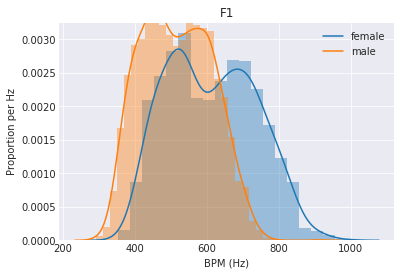

In [78]:
sns.distplot(timit_female['F1'], kde_kws={"label": "female"})
sns.distplot(timit_male['F1'], kde_kws={"label": "male"})
plt.title('F1')
plt.xlabel("BPM (Hz)")
plt.ylabel('Proportion per Hz')

Does there seem to be a notable difference between male and female distributions of F1?

Next, we plot F2.

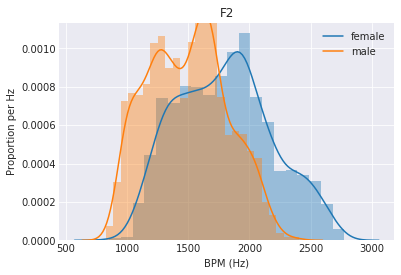

In [79]:
sns.distplot(timit_female['F2'], kde_kws={"label": "female"})
sns.distplot(timit_male['F2'], kde_kws={"label": "male"})
plt.title('F2')
plt.xlabel("BPM (Hz)")
plt.ylabel('Proportion per Hz')

Finally, we create the same visualization, but for F3.

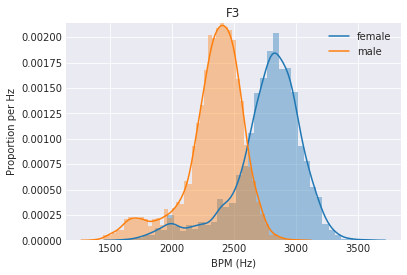

In [80]:
sns.distplot(timit_female['F3'], kde_kws={"label": "female"})
sns.distplot(timit_male['F3'], kde_kws={"label": "male"})
plt.title('F3')
plt.xlabel("BPM (Hz)")
plt.ylabel('Proportion per Hz')

Do you see a more pronounced difference across the the different F values? Are they the same throughout? Can we make any meaningful assumptions from these visualizations?

An additional question: How do you think the fact that we average each vowel together first for each individual affects the shape of the histograms?

## Using the Class's Data

This portion of the notebook will rely on the data that was submit for HW5. Just like we did for the TIMIT data, we are going to read it into a dataframe and modify the column `vowel` to reflect the corresponding IPA translation. We will name the dataframe `class_data`.

In [248]:
# reading in the data
class_data = pd.read_csv('data/110_formants.csv')
class_data.head()

,ID,Language,Gender,Height,vowel,F1,F2,F3
1,1,English,Female,168.0,AA,948,1099,2939
2,1,English,Female,168.0,AE,931,1922,2897
3,1,English,Female,168.0,AH,733,1348,2523
4,1,English,Female,168.0,EH,693,2004,2873
5,1,English,Female,168.0,ER,608,1784,1885


The `ID` column contains a unique value for each individual. Each individual has a row for each of the different vowels they measured.

In [249]:
# translating the vowel column
class_data['vowel'] = [IPAdict[x] for x in class_data['vowel']]
class_data.head()

,ID,Language,Gender,Height,vowel,F1,F2,F3
1,1,English,Female,168.0,ɑ,948,1099,2939
2,1,English,Female,168.0,æ,931,1922,2897
3,1,English,Female,168.0,ʌ,733,1348,2523
4,1,English,Female,168.0,ɛ,693,2004,2873
5,1,English,Female,168.0,ɚ,608,1784,1885


### Splitting on Gender

As we did with the TIMIT data, we are going to split `class_data` based on self-reported gender. We need to figure out what the possible responses for the column were.

In [99]:
class_data.groupby(['ID', 'Gender']).count().reset_index()['Gender'].value_counts()

Female                  12
Male                     5
Prefer not to answer     1
Name: Gender, dtype: int64

Notice that there are three possible values for the column. We do not have a large enough sample size to responsibly come to conclusions for `Prefer not to answer`, so for now we'll compare `Male` and `Female`. We'll call our new split dataframes `class_female` and `class_male`.

In [100]:
class_female = class_data[class_data['Gender'] == 'Female']
class_male = class_data[class_data['Gender'] == 'Male']

### Comparing Distributions

The following visualizations compare the the distribution of formants for males and females, like we did for the TIMIT data.

First, we'll start with `F1`.

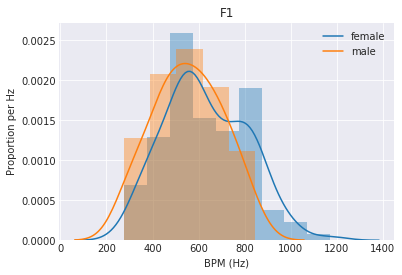

In [101]:
sns.distplot(class_female['F1'], kde_kws={"label": "female"})
sns.distplot(class_male['F1'], kde_kws={"label": "male"})
plt.title('F1')
plt.xlabel("BPM (Hz)")
plt.ylabel('Proportion per Hz')

Next is `F2`.

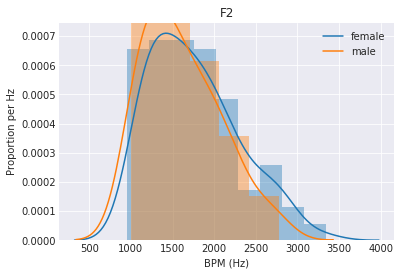

In [102]:
sns.distplot(class_female['F2'], kde_kws={"label": "female"})
sns.distplot(class_male['F2'], kde_kws={"label": "male"})
plt.title('F2')
plt.xlabel("BPM (Hz)")
plt.ylabel('Proportion per Hz')

And finally `F3`.

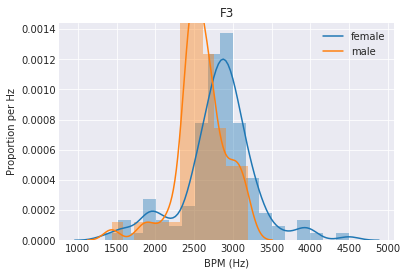

In [103]:
sns.distplot(class_female['F3'], kde_kws={"label": "female"})
sns.distplot(class_male['F3'], kde_kws={"label": "male"})
plt.title('F3')
plt.xlabel("BPM (Hz)")
plt.ylabel('Proportion per Hz')

Do the spread of values appear to be the same for females and males? Do the same patterns that occur in the TIMIT data appear in the class's data?

### Formants vs Height

_description_

comparing max of each formant to height (line represents the general trend) for example, if the line has a negative slope, it means that as height increases (the value on the x-axis), then the value on the y-axis decreases (formant value)

In [268]:
genders = class_data['Gender']
plotting_data = class_data.drop('vowel', axis=1)[np.logical_or(genders == 'Male', genders == 'Female')]
maxes = plotting_data.groupby(['ID', 'Gender']).max().reset_index()
maxes.columns = ['ID', 'Gender', 'Language', 'Height', 'Max F1', 'Max F2', 'Max F3']
maxes_female = maxes[maxes['Gender'] == 'Female']
maxes_male = maxes[maxes['Gender'] == 'Male']
maxes.head()

,ID,Gender,Language,Height,Max F1,Max F2,Max F3
0,1,Female,English,168.00,948,2879,3385
1,2,Female,Mandarin,163.00,881,3080,3550
2,3,Male,English,173.00,682,2256,2904
3,4,Female,English,154.94,836,2788,4497
4,5,Female,English,156.00,1011,3343,4002


First for `Max F1` vs `Height`.

different colors represent the different genders.

female: green
male: orange


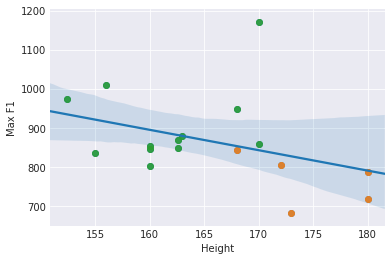

In [281]:
sns.regplot('Height', 'Max F1', data=maxes)
sns.regplot('Height', 'Max F1', data=maxes_male, fit_reg=False)
sns.regplot('Height', 'Max F1', data=maxes_female, fit_reg=False)
print('female: green')
print('male: orange')

do you notice a general trend between the two?

Next, `Max F2` vs `Height`.

female: green
male: orange


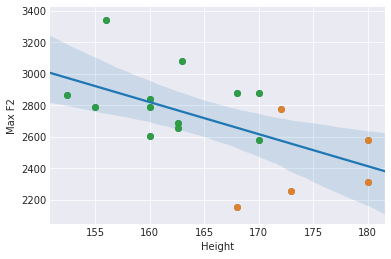

In [282]:
sns.regplot('Height', 'Max F2', data=maxes)
sns.regplot('Height', 'Max F2', data=maxes_male, fit_reg=False)
sns.regplot('Height', 'Max F2', data=maxes_female, fit_reg=False)
print('female: green')
print('male: orange')

Finally, `Max F3` vs `Height`.

female: green
male: orange


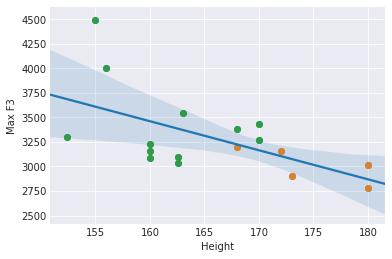

In [283]:
sns.regplot('Height', 'Max F3', data=maxes)
sns.regplot('Height', 'Max F3', data=maxes_male, fit_reg=False)
sns.regplot('Height', 'Max F3', data=maxes_female, fit_reg=False)
print('female: green')
print('male: orange')

separating by gender, before we plotted one line for all of the values.

now we plot two lines of best fit, one for males, one for females.

we're going to use just F1.

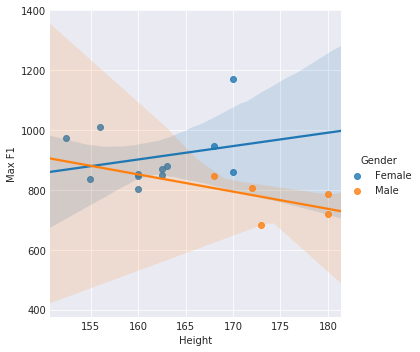

In [280]:
sns.lmplot('Height', 'Max F1', data=maxes, hue='Gender')

Is there a noticeable difference between the two? Did you expect this result.

We're going to repeat the above graph, plotting a different regression line for males and females. Having a larger sample size may help stronger patterns surface.

We have to repeat the process of calulating the maximum value for each formants for each speaker, then we recreate the plot.

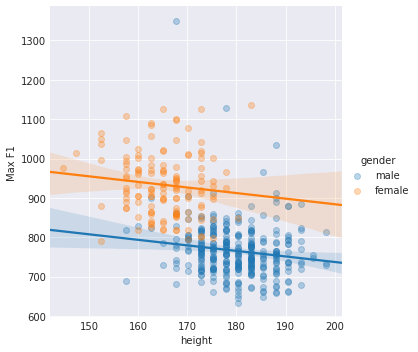

In [288]:
timit_maxes = timit.groupby(['speaker', 'gender']).max().reset_index()
timit_maxes.columns = ['speaker', 'gender', 'region', 'height', 'word', 'vowel', 'Max duration', 'Max F1', 'Max F2', 'Max F3', 'Max f0']
sns.lmplot('height', 'Max F1', data=timit_maxes, hue='gender', scatter_kws={'alpha':0.3})

Do you think similar patterns would emerge for `F2` and `F3`? Consider trying to copy some of the code from above and make slight changes to it (remember that to insert a code cell below, you can either press `esc + b` or click `Insert > Insert Cell Below` on the toolbar).

## 3.2 Understanding Vowel Formants

" The frequency of the first formant <b>(F1)</b> is mostly determined by the height of the tongue body:<br>

<ul>high F1 = <i>low</i> vowel (i.e., high frequency F1 = low tongue body)<br>
low F1 = <i>high</i> vowel (i.e., low frequency F1 = high tongue body)</ul>


The frequency of the second formant <b>(F2)</b> is mostly determined by the frontness/backness of the tongue body:
<br><ul>
high F2 = <i>front</i> vowel<br>
low F2 = <i>back</i> vowel "</ul>

LINK : https://home.cc.umanitoba.ca/~krussll/phonetics/acoustic/formants.html

Below we grouped the data by each vowel and then found the mean of all its values. For the first cell below, we just printed it's results from F1 and put it in descending order. For the second cell we did very similar code, but instead focusing on F2.

Look at the brief definitions of F1 and F2 provided above this cell. Do you notice any trends in regards to the vowels that appeared most in specific genders and their characteristics of being high/low or front/back vowels? Are there any relationships?

## Vowel Spaces

In [235]:
def plot_blank_vowel_chart():
    im = plt.imread('images/blankvowel.png')
    plt.imshow(im, extent=(plt.xlim()[0], plt.xlim()[1], plt.ylim()[0], plt.ylim()[1]))

def plot_vowel_chart():
    plt.figure(figsize=(10, 10))
    im = plt.imread('images/notblank.png')
    plt.imshow(im, extent=(7.7, 6.9, 6.7, 5.9))
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('Log(F2) (descending)')
    plt.ylabel('Log(F1) (descending)')

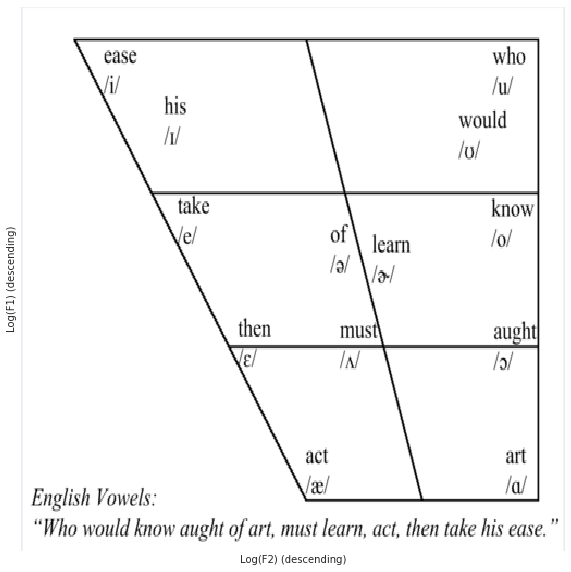

In [236]:
plot_vowel_chart()

We start of by grouping all the rows by their vowel and calculating the mean for each column attribute for each vowel.

In [153]:
timit_vowel_avgs = timit.groupby('vowel').mean()
timit_vowel_avgs.head()

,region,height,duration,F1,F2,F3,f0
vowel,,,,,,,
eɪ,4.322006,175.547107,0.115782,492.412244,2043.718393,2632.371197,142.937756
i,4.266060,175.638252,0.096248,410.808897,2143.726578,2693.280529,153.532916
oʊ,4.226876,175.856863,0.122723,559.736591,1152.477836,2563.795288,150.992205
u,4.209927,175.879342,0.096630,418.927231,1561.519126,2464.922996,148.428415
æ,4.226215,175.410696,0.117523,650.748285,1763.569110,2542.692548,140.606737


In [154]:
class_vowel_avgs = class_data.groupby('vowel').mean()
class_vowel_avgs.head()

,ID,Height,F1,F2,F3
vowel,,,,,
eɪ,9.5,165.192222,508.777778,2344.666667,2947.388889
i,9.5,165.192222,356.500000,2711.222222,3211.444444
oʊ,9.5,165.192222,604.111111,1289.000000,2787.333333
u,9.5,165.192222,406.500000,1445.222222,2731.833333
æ,9.5,165.192222,849.277778,1840.222222,2737.166667


## 4.1 Constructing a Vowel Space

Let's construct a vowel space! Run the cell below to view the vowel space of F1 vs F2.

In [195]:
def plot_vowel_space(avgs_df):
    plt.figure(figsize=(10, 8))
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    for i in range(len(avgs_df)):
        plt.scatter(avgs_df['F2'][i], avgs_df['F1'][i], marker=r"$ {} $".format(avgs_df.index[i]), s=1000)
        
    plt.ylabel('F1')
    plt.xlabel('F2')

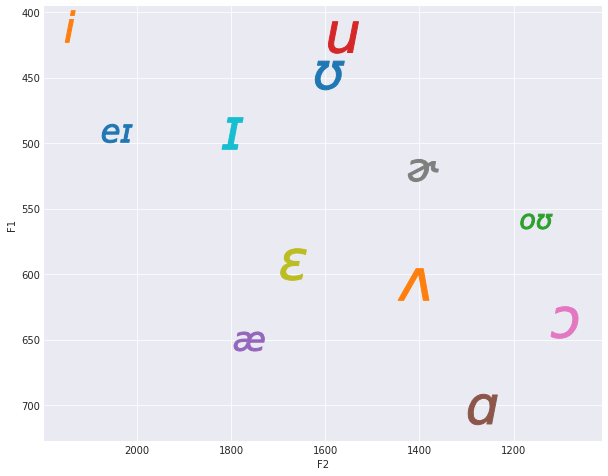

In [196]:
plot_vowel_space(timit_vowel_avgs)

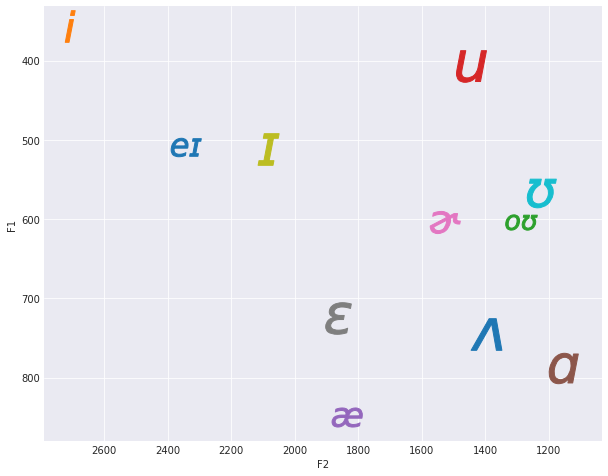

In [197]:
plot_vowel_space(class_vowel_avgs)

## 4.3 Using Logarithmic Axes

In the visualization above we use linear axes in order to construct our vowel space. Lets observe how the vowel space would change using logarithmic axes. The cell below will take the log of all values in our F1 and F2 columns and add them as new columns of our TIMIT table.

In [198]:
log_timit_vowels = timit_vowel_avgs.apply(np.log)
log_class_vowels = class_vowel_avgs.apply(np.log)
log_class.head()

,ID,Height,F1,F2,F3
vowel,,,,,
eɪ,2.251292,5.10711,6.232011,7.759899,7.988675
i,2.251292,5.10711,5.876334,7.905155,8.074476
oʊ,2.251292,5.10711,6.403758,7.161622,7.932841
u,2.251292,5.10711,6.007584,7.276018,7.912728
æ,2.251292,5.10711,6.744386,7.517642,7.914679


Let's plot the new vowel space using these new columns


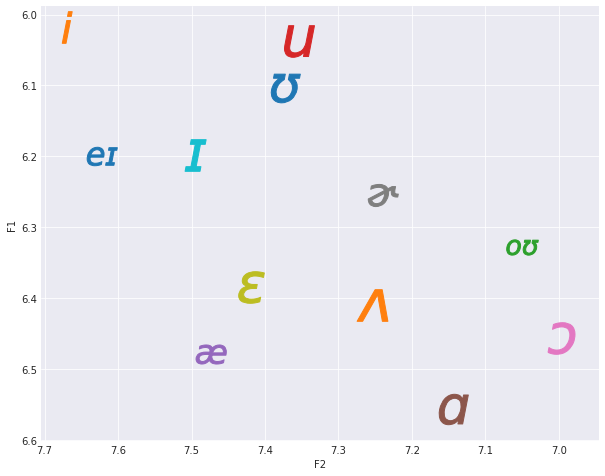

In [199]:
plot_vowel_space(log_timit_vowels)

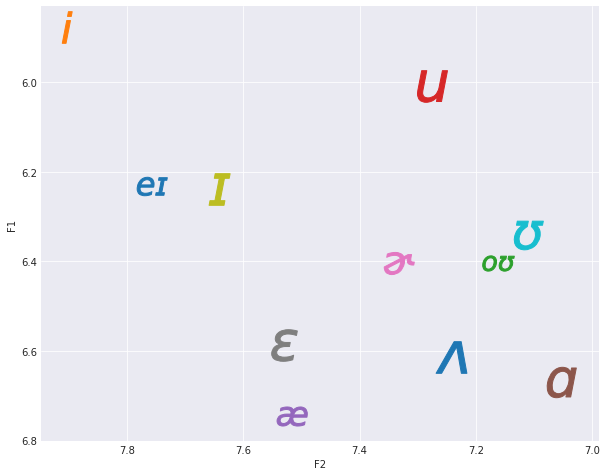

In [200]:
plot_vowel_space(log_class_vowels)

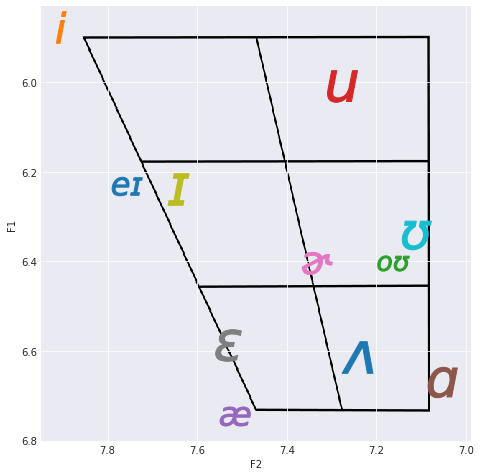

In [238]:
plot_vowel_space(log_class_vowels)
plot_blank_vowel_chart()

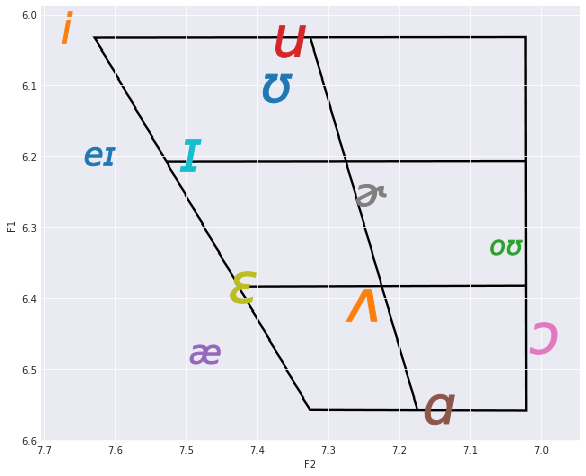

In [237]:
plot_vowel_space(log_timit_vowels)
plot_blank_vowel_chart()

### <font color = "blue"> QUESTION #6 </font>

How would you describe the vowel space above?

__Answer:__

Vowel, Color
eɪ, Greys
i, Purples
oʊ, Blues
u, Greens
æ, Oranges
ɑ, Reds
ɚ, GnBu
ɛ, PuRd
ɪ, winter
ʊ, YlOrBr
ʌ, pink
ɔ, copper


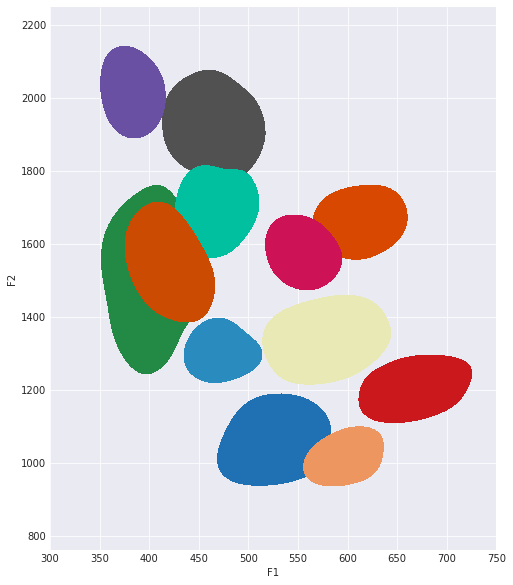

In [266]:
plt.figure(figsize=(8, 10))
pick_vowel = lambda v: timit_avg[timit_avg['vowel'] == v]
colors = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', \
          'Reds', 'GnBu', 'PuRd', 'winter', 'YlOrBr', 'pink', 'copper']

print('Vowel, Color')
for vowel, color in list(zip(timit_avg.vowel.unique(), colors)):
    print('{}, {}'.format(vowel, color))
    vowel_subset = pick_vowel(vowel)
    sns.kdeplot(vowel_subset['F1'], vowel_subset['F2'], n_levels=1,cmap=color, shade=True, shade_lowest=False, label=vowel)
    
plt.xlim(300, 750)
plt.ylim(760, 2250)
plt.legend()
plt.show()

# <font color = red> 6. Drawing Our Own Vowel Space!

## 6.2 Creating Our Vowel Space

### <font color = "blue"> QUESTION #9 </font>

Describe the resulting vowel space. How does it compare with the vowel space from the TIMIT data?

### <font color = "blue"> QUESTION #10 </font>

What may be the cause for any differences between our vowel space and the one constructed using the TIMIT data? Do you notice any outliers or some points that seem off?